In [1]:
import pandas as pd
import os
# time
import pytz
import datetime
# plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as po
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
# maths and statistics
import numpy as np
from scipy.stats import kstest,ks_2samp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
# process mining
import pm4py
from pm4py.objects.log.importer import xes
from pm4py.objects.conversion.log.versions import to_dataframe
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
wd = os.getcwd()
"""
get all filenames in working directory
then collect log containing folders
get log files paths and collect logs

"""
logs_paths = []
for file in os.listdir(wd):
    if file.endswith(".xes_"):
        for f in os.listdir(file):
            if f.endswith(".xes"):
                logs_paths.append(os.path.join(wd+'\\'+file, f))
print(logs_paths)

['C:\\PM contest\\Common challenge\\DomesticDeclarations.xes_\\DomesticDeclarations.xes', 'C:\\PM contest\\Common challenge\\InternationalDeclarations.xes_\\InternationalDeclarations.xes', 'C:\\PM contest\\Common challenge\\PermitLog.xes_\\PermitLog.xes', 'C:\\PM contest\\Common challenge\\PrepaidTravelCost.xes_\\PrepaidTravelCost.xes', 'C:\\PM contest\\Common challenge\\RequestForPayment.xes_\\RequestForPayment.xes']


### Таблицы

In [3]:
domestic_declarations = xes_importer.apply(wd + '\DomesticDeclarations.xes_\DomesticDeclarations.xes')

In [4]:
int_declarations = xes_importer.apply(wd + '\InternationalDeclarations.xes_\InternationalDeclarations.xes')

In [5]:
permit_log = xes_importer.apply(wd + '\PermitLog.xes_\PermitLog.xes')

In [6]:
prepaid_travel_cost = xes_importer.apply(wd + '\PrepaidTravelCost.xes_\PrepaidTravelCost.xes')

In [7]:
request_for_payment = xes_importer.apply(wd + '\RequestForPayment.xes_\RequestForPayment.xes')

In [8]:
permit_log = pd.read_csv('C://PM contest//Common challenge//PermitLog.xes_//compact_PermitLog.csv')
permit_log['time:timestamp']=permit_log['time:timestamp'].map(lambda x: datetime.datetime.fromisoformat(x))

In [9]:
domestic_declarations = to_dataframe.apply(domestic_declarations)
int_declarations = to_dataframe.apply(int_declarations)
permit_log = to_dataframe.apply(permit_log)
prepaid_travel_cost = to_dataframe.apply(prepaid_travel_cost)
request_for_payment = to_dataframe.apply(request_for_payment)

In [10]:
dfs_list = [domestic_declarations,int_declarations,permit_log,prepaid_travel_cost,request_for_payment]

### Timestamp with timezone --> timestamp unified

In [11]:
"""
converts to UTC-format for unified timestamp format
:param: df - selected table
:param: time_column - column with the following time format %Y-%m-%d HH:MM:SS+0X:00
:return: converted to UTC-format timestmp without timezone
"""

def to_utc(df, time_column):
    utc = pytz.timezone('UTC')
    df[time_column] = df[time_column].map(lambda x: x.astimezone(utc).replace(tzinfo=None))
    return df

In [12]:
for df in dfs_list:
    df = to_utc(df, 'time:timestamp')

# Questions

### 1. What is the throughput of a travel declaration from submission (or closing) to paying?

In [18]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [19]:
""" 
time delta between events for each event type its first mention is used
:param: df - selected table
:param: id_column - column where case id is stored
:param: concept_column - column where case name is stored
:param: eventlist - list where selected events are stored 
:param: time_column - column where timestamp in the format is stored timestamp(%Y-%m-%d HH:MM:SS)
:return: table with description statistics, 
         table with initial data: declaration ids, timedelta, timedelta in hours
"""

def events_time_delta(df, id_column, concept_column, eventlist, time_column):
    df=df.sort_values([id_column, time_column],ascending = True)
    throughoutput = df[df[concept_column].isin(set(eventlist))]
    throughoutput = throughoutput.drop_duplicates(subset = [id_column, concept_column], keep = 'first')
    tmp = pd.DataFrame(throughoutput.groupby([id_column]).apply(lambda x: list(x[time_column])))
    tmp = tmp.reset_index()
    tmp.columns = [id_column, 'timing']
    tmp['length'] = tmp['timing'].map(lambda x: len(x))
    tmp['throughoutput'] = None
    # the function does not count timedelta for events that are not finished
    tmp_selected = tmp[tmp['length']==2]
    tmp_selected['throughoutput'] = tmp_selected['timing'].map(lambda x: x[1]-x[0])
    tmp_selected['throughoutput_days']=tmp_selected['throughoutput'].map(lambda x: x.total_seconds()/(24*60*60))
    tmp_selected = tmp_selected.drop(['length', 'timing'], axis =1)
    tmp_selected['start_case']=eventlist[0]
    tmp_selected['end_case'] = eventlist[1]
    tmp_selected = tmp_selected[['case:id','start_case','end_case','throughoutput_days','throughoutput']]
    return pd.DataFrame(tmp_selected['throughoutput_days'].describe()), tmp_selected

#### Exploration part

In [32]:
t1, t2 = events_time_delta(id_18,
                          id_column='case:id',
                          concept_column='concept:name',
                          eventlist = ['Declaration SUBMITTED by EMPLOYEE','Payment Handled'],
                          time_column = 'time:timestamp')

In [33]:
t1

,throughoutput_days
count,4734.000000
mean,14.236223
std,14.135641
min,1.087350
25%,7.005984
50%,10.298229
75%,16.381490
max,272.201134


In [34]:
t2.head()

,case:id,start_case,end_case,throughoutput_days,throughoutput
0,declaration 1002,Declaration SUBMITTED by EMPLOYEE,Payment Handled,13.052731,13 days 01:15:56
1,declaration 10024,Declaration SUBMITTED by EMPLOYEE,Payment Handled,6.849410,6 days 20:23:09
2,declaration 10026,Declaration SUBMITTED by EMPLOYEE,Payment Handled,8.038183,8 days 00:54:59
3,declaration 10046,Declaration SUBMITTED by EMPLOYEE,Payment Handled,2.253241,2 days 06:04:40
4,declaration 10069,Declaration SUBMITTED by EMPLOYEE,Payment Handled,6.352049,6 days 08:26:57


### 2. What is the throughput in each of the process steps, i.e. the submission, judgement by various responsible roles and payment?

In [35]:
def time_period_selection(df, start_date, end_date, time_column):
    df = df[(df[time_column]>=start_date)&(df[time_column]<=end_date)]
    return df

In [36]:
"""
counts time of execution between all traces that are mentioned in the log
:params: df - table of the log
:params: time_column - column where the time of event is stored
:params: case_id - column name where case id is stored
:params: case_concept - column where event names are stored
:params: numtop - number of TOP-longest traces of df to show
:return: pdf graph of the process and a table with top longest traces (time of execution is averaged among all declarations)
"""


def top_longest_cases(df, time_column, case_id, case_concept, numtop):
    log = conversion_factory.apply(df)
    dfg = dfg_factory.apply(log)
    stat_tables = []
    full_tables = []
    for trace in dfg:
        t1, t2 = events_time_delta(df, 'case:id', 'concept:name', list(trace), 'time:timestamp')
        stat_tables.append(t1)
        full_tables.append(t2)
    mean_tp = pd.concat(full_tables)
    grouped = mean_tp.groupby(['start_case','end_case'])[['throughoutput_days']].mean()\
                                                                                .nlargest(numtop,['throughoutput_days'])
    dfg = dfg_factory.apply(log, variant="performance")
    gviz = dfg_vis_factory.apply(dfg, log=log, variant="performance")
    gviz.render("timing_graph")
    print('timing_graph.png')
    return grouped

In [37]:
test = time_period_selection(id_18,
                      '2018-01-01 00:00:00',
                      domestic_declarations['time:timestamp'].max(),
                      'time:timestamp')

In [ ]:
top_longest_cases(test, 'time:timestamp', 'case:id', 'concept:name', 10).to_excel('top_longest_id.xlsx')

In [58]:
test = test[['case:id', 'time:timestamp', 'concept:name']]

In [59]:
log = conversion_factory.apply(test)

KeyError: 'case:concept:name'

In [75]:
test['concept:name'].value_counts()

Declaration SUBMITTED by EMPLOYEE           6586
End trip                                    5176
Start trip                                  5122
Declaration APPROVED by ADMINISTRATION      5019
Permit SUBMITTED by EMPLOYEE                4923
Permit APPROVED by ADMINISTRATION           4839
Request Payment                             4799
Payment Handled                             4764
Declaration FINAL_APPROVED by SUPERVISOR    4679
Permit FINAL_APPROVED by SUPERVISOR         4288
Declaration APPROVED by BUDGET OWNER        1810
Permit APPROVED by BUDGET OWNER             1763
Declaration REJECTED by EMPLOYEE            1667
Declaration REJECTED by ADMINISTRATION      1549
Permit APPROVED by SUPERVISOR                450
Permit FINAL_APPROVED by DIRECTOR            449
Send Reminder                                432
Permit REJECTED by EMPLOYEE                  187
Declaration APPROVED by SUPERVISOR           155
Declaration FINAL_APPROVED by DIRECTOR       152
Declaration REJECTED

In [76]:
from pm4py.statistics.performance_spectrum import algorithm as performance_spectrum
ps = performance_spectrum.apply(log, ["Declaration SUBMITTED by EMPLOYEE", "Payment Handled"],
                                parameters={performance_spectrum.Parameters.ACTIVITY_KEY: "concept:name",
                                            performance_spectrum.Parameters.TIMESTAMP_KEY: "time:timestamp"})
                                    

In [82]:
t = pd.DataFrame(ps['points'])

In [83]:
t['dif'] = t[1]-t[0]

In [87]:
t['dif'] = t['dif'].map(lambda x: x//24)

In [92]:
t['dif'].max()//30

9.0

### 3. Is there are difference in throughput between national and international trips?

In [30]:
td_17 = time_period_selection(domestic_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
td_18 = time_period_selection(domestic_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

ti_17 = time_period_selection(int_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
ti_18 = time_period_selection(int_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

In [31]:
dd_17= td_17.copy()
dd_18 = td_18.copy()

id_17= ti_17.copy()
id_18 = ti_18.copy()

In [69]:
len(set(dd_17['case:id'])), len(set(dd_18['case:id']))

(2240, 8345)

In [70]:
len(set(id_17['case:id'])), len(set(id_18['case:id']))

(1552, 5322)

In [71]:
dd_17['date'] = dd_17['time:timestamp'].map(lambda x: x.week)
dd_18['date'] = dd_18['time:timestamp'].map(lambda x: x.week)

id_17['date'] = id_17['time:timestamp'].map(lambda x: x.week)
id_18['date'] = id_18['time:timestamp'].map(lambda x: x.week)

In [72]:
dd_18.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount,date
1011,st_step 100203_0,STAFF MEMBER,Declaration REJECTED by MISSING,2018-01-08 12:54:03,MISSING,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,2
1012,st_step 100199_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-08 15:35:34,EMPLOYEE,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,2
1013,st_step 100202_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-01-08 15:36:03,ADMINISTRATION,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,2
1014,st_step 100201_0,STAFF MEMBER,Declaration APPROVED by BUDGET OWNER,2018-01-16 09:19:31,BUDGET OWNER,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,3
1015,st_step 100200_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-18 11:19:48,SUPERVISOR,declaration 100197,declaration 100197,budget 86566,declaration number 100198,9.759093,3


In [73]:
# количество заявок
gd_17 = dd_17.groupby(['date'])[['case:id']].nunique()
gd_18 = dd_18.groupby(['date'])[['case:id']].nunique()

# количество заявок
gi_17 = id_17.groupby(['date'])[['case:id']].nunique()
gi_18 = id_18.groupby(['date'])[['case:id']].nunique()

In [74]:
fig_1 = make_subplots(rows = 2, cols = 2, start_cell = 'top-left',
                     subplot_titles = ['Кол-во обрабатываемых DD в неделю, 2017','Кол-во обрабатываемых DD в неделю, 2018',
                                      'Кол-во обрабатываемых ID в неделю, 2017','Кол-во обрабатываемых ID в неделю, 2018'])

In [75]:
fig_1.add_trace(go.Scatter(x = dd_17.groupby(['date'])[['case:id']].nunique().reset_index()['date'].to_list(),
      y = dd_17.groupby(['date'])[['case:id']].nunique()['case:id'].to_list(),
      text = dd_17.groupby(['date'])[['case:id']].nunique()['case:id'].to_list()),
      row = 1, col = 1)          
fig_1.add_trace(go.Scatter(x = dd_18.groupby(['date'])[['case:id']].nunique().reset_index()['date'].to_list(),
      y = dd_18.groupby(['date'])[['case:id']].nunique()['case:id'].to_list(),
      text = dd_18.groupby(['date'])[['case:id']].nunique()['case:id'].to_list()),
      row = 1, col = 2)  


fig_1.add_trace(go.Scatter(x = id_17.groupby(['date'])[['case:id']].nunique().reset_index()['date'].to_list(),
      y = id_17.groupby(['date'])[['case:id']].nunique()['case:id'].to_list(),
      text = id_17.groupby(['date'])[['case:id']].nunique()['case:id'].to_list()),
      row = 2, col = 1)          
fig_1.add_trace(go.Scatter(x = id_18.groupby(['date'])[['case:id']].nunique().reset_index()['date'].to_list(),
      y = id_18.groupby(['date'])[['case:id']].nunique()['case:id'].to_list(),
      text = id_18.groupby(['date'])[['case:id']].nunique()['case:id'].to_list()),
      row = 2, col = 2)  


fig_1.update_layout(title = 'Amount of processed declarations on week basis',
                 height = 800, width = 1000)
po.plot(fig_1, filename = 'num_declarations_week.html')

'num_declarations_week.html'

In [76]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

> Проверка рядов на стационарность: если ряд __стационарен__, значит, он __постоянен во времени__ и не меняет свои характеристики. 
Стационарность проверяется при помощи __теста Дики-Фуллера__. Если p-value меньше уровня значимости, то ряд стационарен. 
Если ряд не стационарен, то его нужно приводить к стационарному взятием разностей. Прежде чем проверить на наличие __сезонности__ ряды нужно привести к __стационарным__.

> Частная автокорреляционная функция показывает наличие зависимости между предыдущими периодами. Так мы можем примерно прикинуть лаг, с которого ряд станет стационарным. Все, что выходит за границы синего прямоугольника считается значимым отклонением.

In [77]:
def tsplot(y, spec, ml, lags=50, figsize=(12, 7), style='bmh'):
    #y = y.fillna(0)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        name = 'Time Series Analysis Plots '+','+str(spec)
        ts_ax.set_title(name)
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        r = adfuller(y, maxlag = ml)
        print("Критерий Дики-Фуллера: p=%f" % r[1])
        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.025252


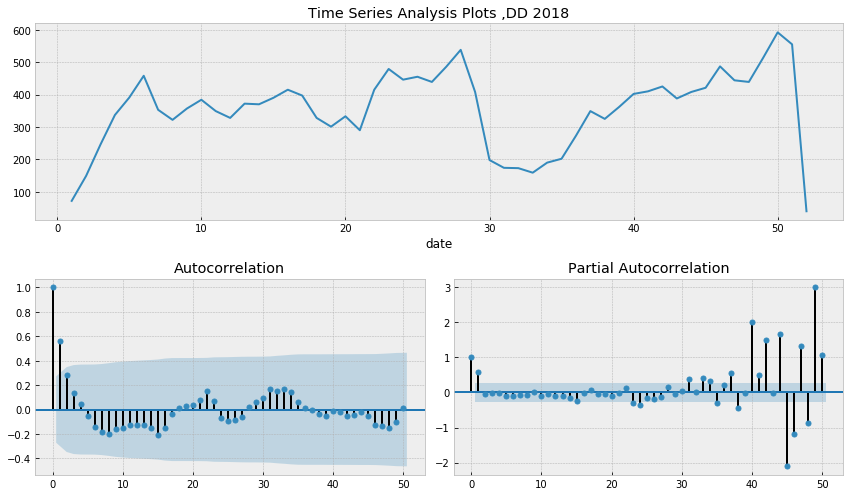

In [78]:
tsplot(gd_18['case:id'], 'DD 2018', 0)

> Ряд стационарный, приводить ни к чему не нужно. И яркая сезонность (никакой магии) еженедельная.

Критерий Дики-Фуллера: p=0.025313


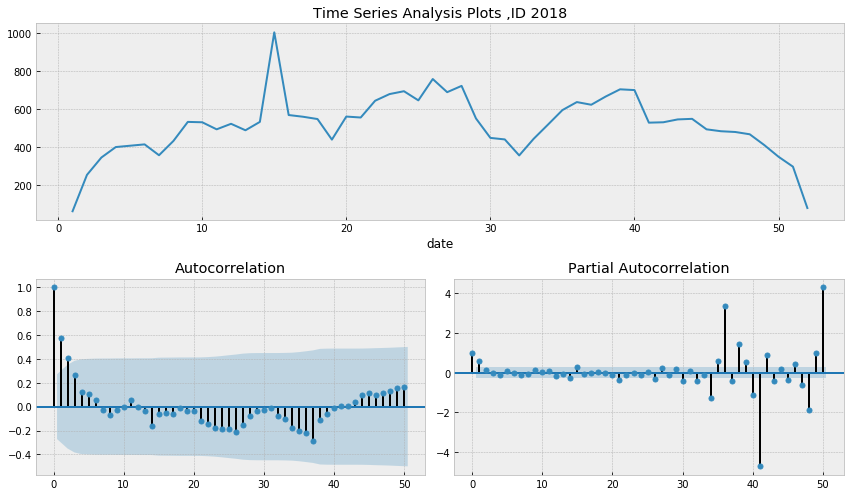

In [79]:
tsplot(gi_18['case:id'], 'ID 2018', 0)

> Ряд международных деклараций не стационарный при любых лагах. Домашних деклараций - стационарный

In [80]:
test_id = id_18.groupby(['date','case:id'])[['concept:name']].nunique().reset_index().groupby(['date']).agg({"case:id":"nunique",
                                                                                                   "concept:name":"mean"})
test_dd = dd_18.groupby(['date','case:id'])[['concept:name']].nunique().reset_index().groupby(['date']).agg({"case:id":"nunique",
                                                                                                   "concept:name":"mean"})

In [81]:
test_dd.head()

,case:id,concept:name
date,,
1,72,1.138889
2,149,3.040268
3,246,2.617886
4,337,2.528190
5,391,2.404092


In [82]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(test_dd[['case:id','concept:name']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7211  , p=0.4000  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=0.7661  , p=0.3814  , df=1
likelihood ratio test: chi2=0.7605  , p=0.3832  , df=1
parameter F test:         F=0.7211  , p=0.4000  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1647  , p=0.8487  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=0.3660  , p=0.8328  , df=2
likelihood ratio test: chi2=0.3646  , p=0.8333  , df=2
parameter F test:         F=0.1647  , p=0.8487  , df_denom=45, df_num=2


{1: ({'ssr_ftest': (0.7210811803680912, 0.4000048638354976, 48.0, 1),
   'ssr_chi2test': (0.7661487541410968, 0.3814111092251157, 1),
   'lrtest': (0.7604510021022861, 0.38318741954875823, 1),
   'params_ftest': (0.7210811803680954, 0.40000486383549594, 48.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.1646884938065511, 0.8486667409232935, 45.0, 2),
   'ssr_chi2test': (0.36597443068122465, 0.8327788024623682, 2),
   'lrtest': (0.3646415578552933, 0.8333339815555088, 2),
   'params_ftest': (0.16468849380655054, 0.8486667409232935, 45.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [83]:
grangercausalitytests(test_id[['case:id','concept:name']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8366  , p=0.0560  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=4.0764  , p=0.0435  , df=1
likelihood ratio test: chi2=3.9217  , p=0.0477  , df=1
parameter F test:         F=3.8366  , p=0.0560  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3651  , p=0.0185  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=9.7003  , p=0.0078  , df=2
likelihood ratio test: chi2=8.8657  , p=0.0119  , df=2
parameter F test:         F=4.3651  , p=0.0185  , df_denom=45, df_num=2


{1: ({'ssr_ftest': (3.8366373132256593, 0.055967749319602196, 48.0, 1),
   'ssr_chi2test': (4.076427145302263, 0.043485516982261455, 1),
   'lrtest': (3.9217047918477874, 0.04766651994455388, 1),
   'params_ftest': (3.8366373132256646, 0.055967749319601995, 48.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.365149006451631, 0.018507529447968022, 45.0, 2),
   'ssr_chi2test': (9.700331125448068, 0.007827081568999923, 2),
   'lrtest': (8.865728072247293, 0.01188041496286408, 2),
   'params_ftest': (4.365149006451616, 0.018507529447968244, 45.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

> __Гипотеза__: есть зависимость между кол-вом обрабатываемых заявок в неделю со временем, то есть система не справляется с высокой нагрузкой. 

>__Коинтеграция временных рядов__ - причинно-следственная зависимость в уровнях двух (более) врем. рядов, которая выражается в совпадении или противоположной направленности их тенденций и случайной колеблемости

> Гипотезы о том, что загруженность влияет подтвердились тестром Гренджера.

### Десезонализация

In [84]:
pl.rcParams['figure.figsize'] = (14, 9)

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose

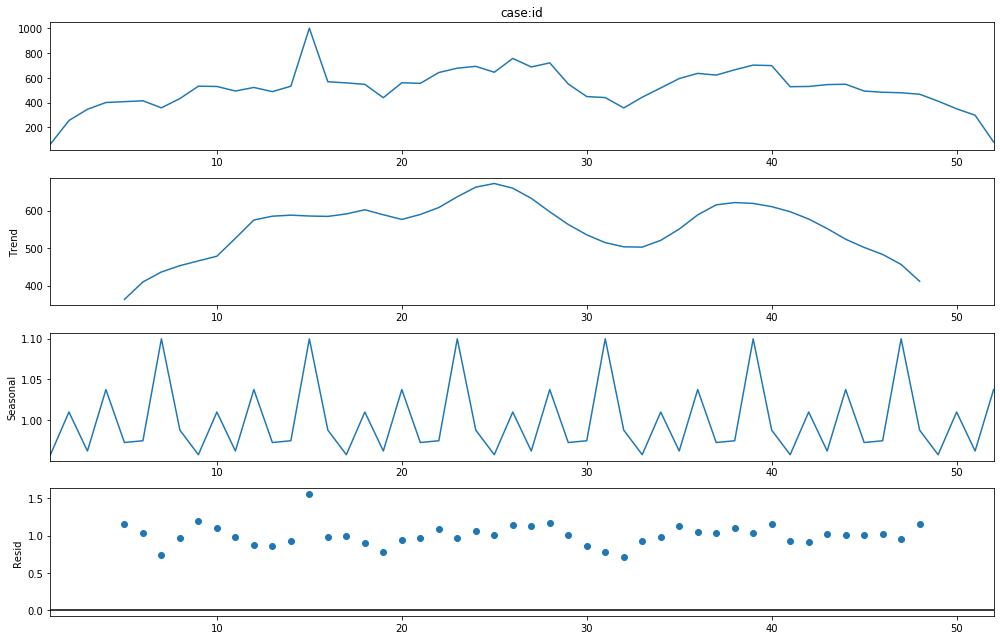

In [86]:
res_id = seasonal_decompose(test_id['case:id'], model='multiplicative', freq=8).plot()

In [87]:
res_dd = seasonal_decompose(test_dd['case:id'], model='multiplicative', freq=7)

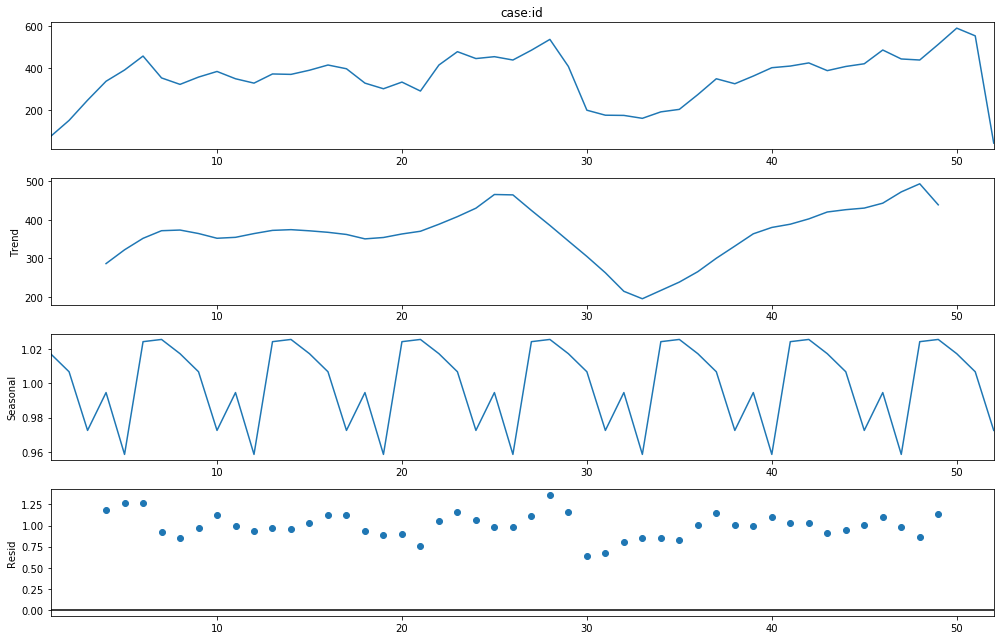

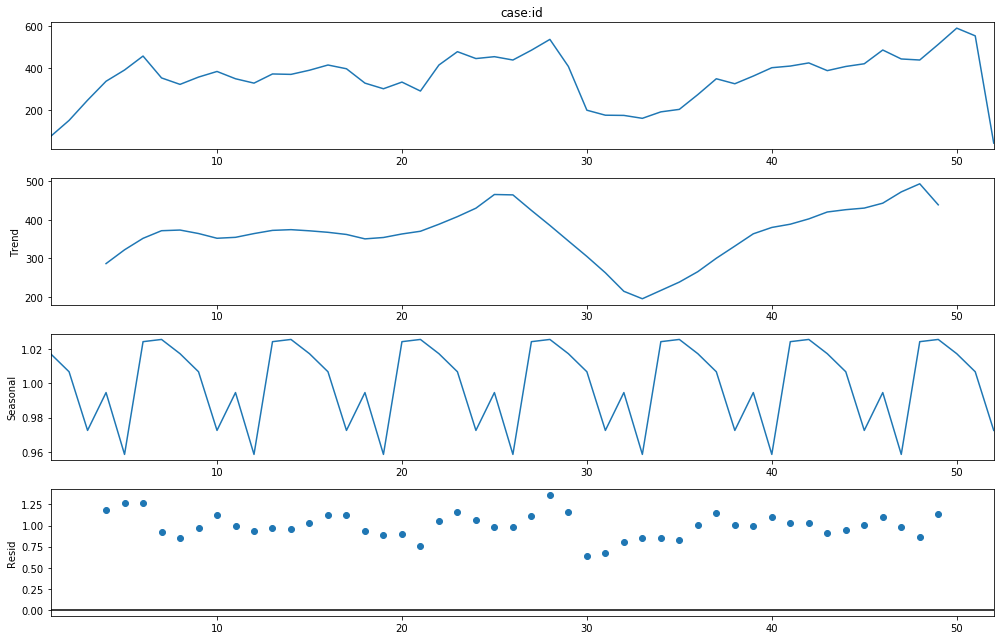

In [88]:
res_dd.plot()

In [89]:
dd_trend = pd.DataFrame(res_dd.trend)
dd_seasonal = pd.DataFrame(res_dd.seasonal)
dd_resid = pd.DataFrame(res_dd.resid)
dd_obs = pd.DataFrame(res_dd.observed)

> Сезонности в данных нет